# Install

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 16.0MB/s 


# Evn

In [ ]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as KK

from tqdm.notebook import tqdm

In [ ]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [ ]:
!nvidia-smi

Mon Feb  8 04:09:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data dir
data_dir = '/content/drive/MyDrive/자연어처리(NLP)/data'
os.listdir(data_dir)

['kowiki',
 'ko_32000.model',
 'ko_32000.vocab',
 '.ipynb_checkpoints',
 'nsmc',
 'quora',
 'songys']

In [ ]:
# songys chatbot dir
songys_dir = os.path.join(data_dir, 'songys')
if not os.path.exists(songys_dir):
    os.makedirs(songys_dir)
os.listdir(songys_dir)

['ChatbotData.csv', 'lstm.csv', 'lstm.hdf5', 'lstm_dot.csv', 'lstm_dot.hdf5']

# Attention

In [ ]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    # 0인 부분 확인
    mask = tf.math.equal(tokens, i_pad)
    # boolean -> float 32
    mask = tf.cast(mask, tf.float32)
    # expand dimension for n_seq
    mask = tf.expand_dims(mask, axis=1)
    return mask

In [ ]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: Q, K, V, attn_mask tuple
        :return attn_out: attention 실행 결과
        """
        Q, K, V, attn_mask = inputs
        # matmul Q, K (transpose_b=True)
        attn_score = tf.matmul(Q, K, transpose_b=True)
        # get scale = d_model ** 0.5
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        # divide by scale
        attn_scale = tf.math.divide(attn_score, scale)
        # do mask (subtract 1e-9 for masked value)
        attn_scale -= 1.e9 * attn_mask
        # calculate attention prob
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        # weighted sum of V
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

# Vocabulary & config

In [ ]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(data_dir, 'ko_32000.model'))

True

In [ ]:
n_vocab = len(vocab)  # number of vocabulary
n_enc_seq = 32  # number of sequence 1
n_dec_seq = 40  # number of sequence 2
d_model = 256  # dimension of model

# 모델링

In [ ]:
def build_model(n_vocab, d_model, n_enc_seq, n_dec_seq):
    """
    문장 유사도 비교 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_enc_seq: encoder 문장 길이 (단어 수)
    :param n_dec_seq: decoder 문장 길이 (단어 수)
    """
    inputs_enc = tf.keras.layers.Input((n_enc_seq,))  # (bs, n_enc_seq)
    inputs_dec = tf.keras.layers.Input((n_dec_seq,))  # (bs, n_dec_seq)
    # pad mask 생성
    ###############################################
    enc_dec_mask = get_pad_mask(inputs_enc)
    ###############################################
    # 입력 단어를 vector로 변환
    embedding = tf.keras.layers.Embedding(n_vocab, d_model)
    hidden_enc = embedding(inputs_enc)  # (bs, n_enc_seq, d_model)
    hidden_dec = embedding(inputs_dec)  # (bs, n_dec_seq, d_model)
    # encoder LSTM
    fw_cell = tf.keras.layers.LSTM(units=d_model, return_sequences=True, return_state=True)
    bw_cell = tf.keras.layers.LSTM(units=d_model, go_backwards=True, return_sequences=True, return_state=True)
    lstm_enc = tf.keras.layers.Bidirectional(fw_cell, backward_layer=bw_cell)
    hidden_enc, fw_h, fw_c, bw_h, bw_c = lstm_enc(hidden_enc)  # (bs, n_enc_seq, d_model * 2), (bs, d_model), (bs, d_model), (bs, d_model), (bs, d_model)
    # concat hidden & cell
    s_h = tf.concat([fw_h, bw_h], axis=-1)  # (bs, d_model * 2)
    s_c = tf.concat([fw_c, bw_c], axis=-1)  # (bs, d_model * 2)
    # decoder LSTM
    lstm_dec = tf.keras.layers.LSTM(units=d_model * 2, return_sequences=True)
    hidden_dec = lstm_dec(hidden_dec, initial_state=[s_h, s_c])  # (bs, n_dec_seq, d_model)
    # ScaleDotProductAttention 실행
    ##############################################
    Q = hidden_dec
    K = hidden_enc
    V = hidden_enc
    attention = ScaleDotProductAttention()
    attn_out = attention((Q, K, V, enc_dec_mask))
    ##############################################
    # concat output
    dec_out = tf.concat([attn_out, hidden_dec], axis=-1)
    # 다음단어 예측
    dense_out = tf.keras.layers.Dense(units=n_vocab, activation=tf.nn.softmax)
    outputs = dense_out(dec_out)  # (bs, n_dec_seq, n_vocab)
    # 학습할 모델 선언
    model = tf.keras.Model(inputs=(inputs_enc, inputs_dec), outputs=outputs)
    return model

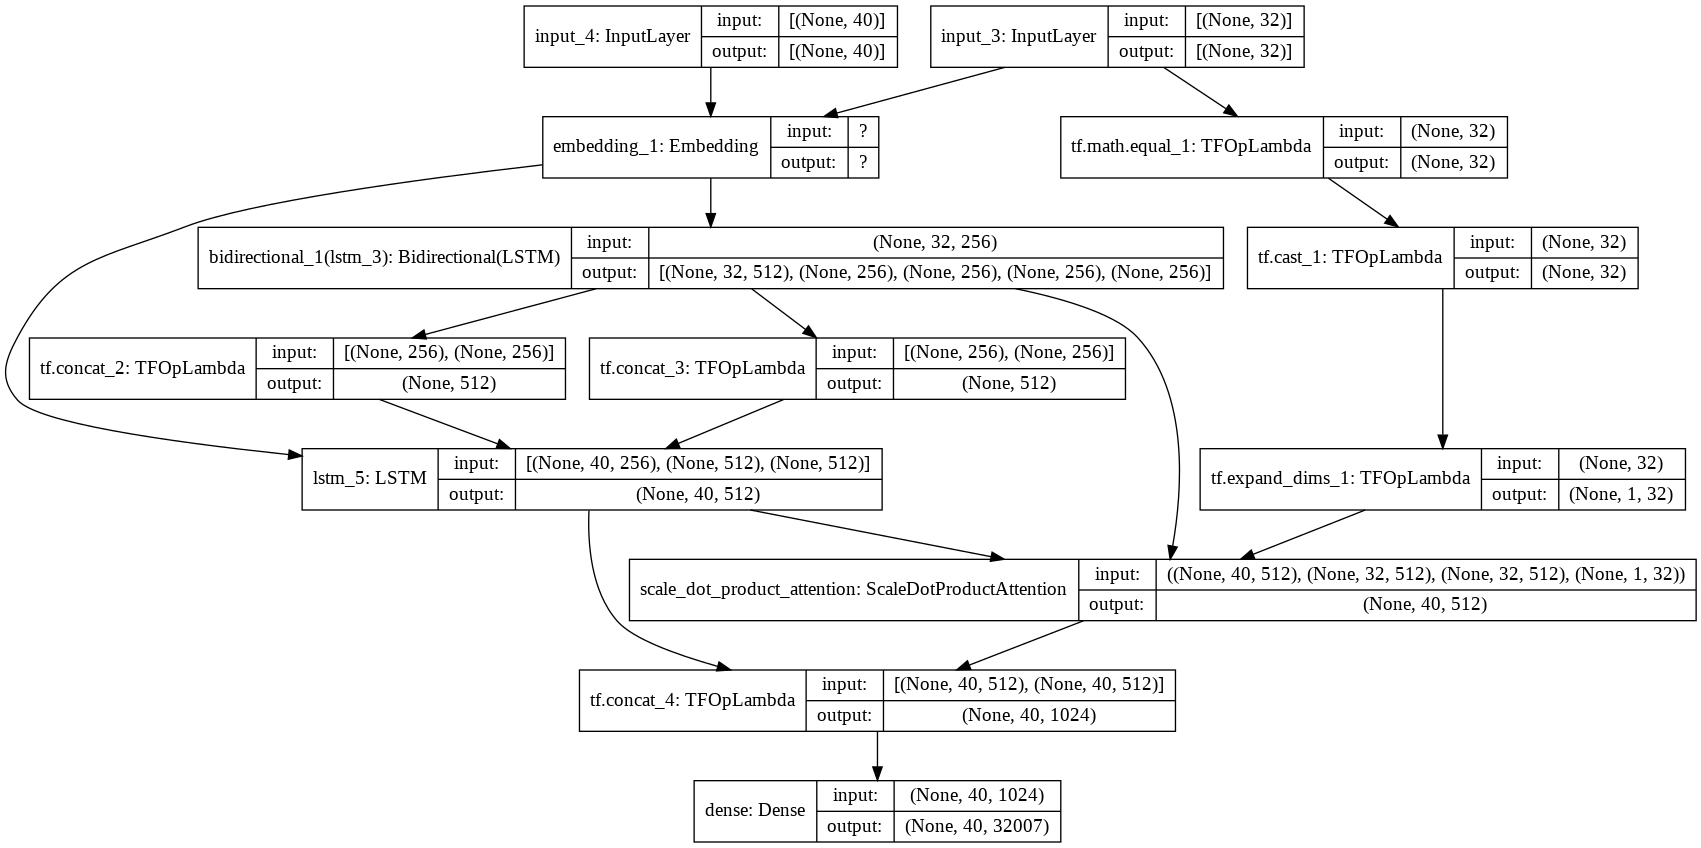

In [ ]:
# 모델 생성
model = build_model(len(vocab), d_model, n_enc_seq, n_dec_seq)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

# Loss & Acc

In [ ]:
def lm_loss(y_true, y_pred):
    """
    pad 부분을 제외하고 loss를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 loss 값
    """
    # loss = sparse_entropy = tf.keras.losses.SparseCategoricalCrossentropy()(y_true, y_pred)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    # print(mask)
    loss *= mask
    return loss

In [ ]:
def lm_acc(y_true, y_pred):
    """
    pad 부분을 제외하고 accuracy를 계산하는 함수
    :param y_true: 정답
    :param y_pred: 예측 값
    :retrun loss: pad 부분이 제외된 accuracy 값
    """
    y_true = tf.cast(y_true, tf.float32)
    # print(y_true)
    y_pred_class = tf.cast(tf.argmax(y_pred, axis=-1), tf.float32)
    # print(y_pred_class)
    matches = tf.cast(tf.equal(y_true, y_pred_class), tf.float32)
    # print(matches)
    mask = tf.not_equal(y_true, 0)
    mask = tf.cast(mask, tf.float32)
    # print(mask)
    matches *= mask
    # print(matches)
    # accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(tf.ones_like(matches)), 1)
    accuracy = tf.reduce_sum(matches) / tf.maximum(tf.reduce_sum(mask), 1)
    return accuracy

# All Data Project

## Data


In [ ]:
df_train = pd.read_csv(os.path.join(songys_dir, 'ChatbotData.csv'))
print(len(df_train))
df_train = df_train.dropna()
print(len(df_train))
df_train

11823
11823


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
...,...,...,...
11818,훔쳐보는 것도 눈치 보임.,티가 나니까 눈치가 보이는 거죠!,2
11819,훔쳐보는 것도 눈치 보임.,훔쳐보는 거 티나나봐요.,2
11820,흑기사 해주는 짝남.,설렜겠어요.,2
11821,힘든 연애 좋은 연애라는게 무슨 차이일까?,잘 헤어질 수 있는 사이 여부인 거 같아요.,2


In [ ]:
def load_data(df, n_enc_seq, n_dec_seq):
    """
    Quora 학습 데이터 생성
    :param df: data frame
    :param n_enc_seq: number of encoder sequence
    :param n_dec_seq: number of decoder sequence
    :return enc_inputs: encoder input data
    :return dec_inputs: decoder input data
    :return labels: label data
    """
    n_enc_max = n_enc_seq
    n_dec_max = n_dec_seq - 1
    enc_inputs = np.zeros((len(df), n_enc_seq)).astype(np.int32)
    dec_inputs = np.zeros((len(df), n_dec_seq)).astype(np.int32)
    labels = np.zeros((len(df), n_dec_seq)).astype(np.int32)
    index = 0
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # tokens 저장
        Q = row['Q']
        A = row['A']

        tokens_q = vocab.encode_as_pieces(Q)
        tokens_a = vocab.encode_as_pieces(A)

        tokens_ids_q = vocab.encode_as_ids(Q)[:n_enc_max]
        tokens_ids_a = vocab.encode_as_ids(A)[:n_dec_max]

        tokens_dec_in = [vocab.bos_id()] + tokens_ids_a
        tokens_dec_out = tokens_ids_a + [vocab.eos_id()]

        tokens_ids_q += [0] * (n_enc_seq - len(tokens_ids_q))
        tokens_dec_in += [0] * (n_dec_seq - len(tokens_dec_in))
        tokens_dec_out += [0] * (n_dec_seq - len(tokens_dec_out))

        enc_inputs[index] = tokens_ids_q
        dec_inputs[index] = tokens_dec_in
        labels[index] = tokens_dec_out
        index += 1
    return enc_inputs, dec_inputs, labels

In [ ]:
# train data 생성
train_enc_inputs, train_dec_inputs, train_labels = load_data(df_train, n_enc_seq, n_dec_seq)
train_enc_inputs, train_dec_inputs, train_labels

(array([[   89,    56,    10, ...,     0,     0,     0],
        [   35,    47,  1004, ...,     0,     0,     0],
        [   38,   819,   362, ...,     0,     0,     0],
        ...,
        [ 2886,  9525, 21930, ...,     0,     0,     0],
        [10736,  8256,  1172, ...,     0,     0,     0],
        [26128,    70,  1381, ...,     0,     0,     0]], dtype=int32),
 array([[    2,  2261,    19, ...,     0,     0,     0],
        [    2,  4594,    61, ...,     0,     0,     0],
        [    2,  2350,    18, ...,     0,     0,     0],
        ...,
        [    2,  1522,     1, ...,     0,     0,     0],
        [    2,   441, 10316, ...,     0,     0,     0],
        [    2, 16665,    90, ...,     0,     0,     0]], dtype=int32),
 array([[ 2261,    19,   375, ...,     0,     0,     0],
        [ 4594,    61,   929, ...,     0,     0,     0],
        [ 2350,    18,  9001, ...,     0,     0,     0],
        ...,
        [ 1522,     1, 12273, ...,     0,     0,     0],
        [  441, 103

## 학습

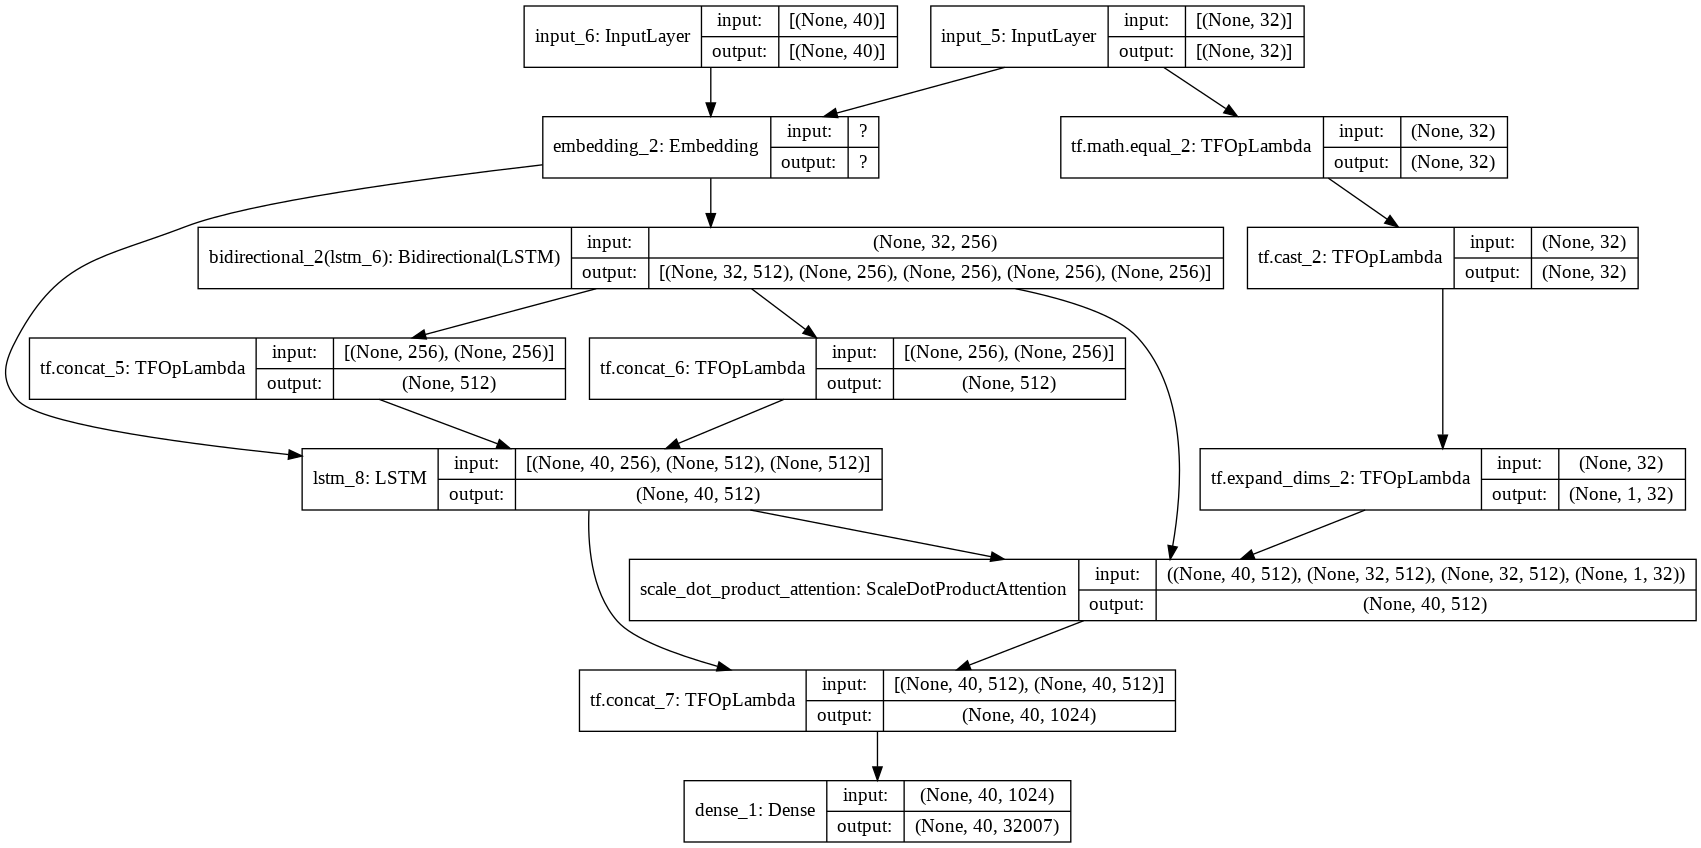

In [ ]:
# 모델 생성
model = build_model(len(vocab), d_model, n_enc_seq, n_dec_seq)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
# 모델 loss, optimizer, metric 정의
model.compile(loss=lm_loss, optimizer='adam', metrics=[lm_acc])

In [ ]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='lm_acc', patience=5)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(songys_dir, 'lstm_scale_dot.hdf5'),
                                                  monitor='lm_acc',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(songys_dir, 'lstm_scale_dot.csv'))

In [ ]:
# 모델 학습
history = model.fit((train_enc_inputs, train_dec_inputs),
                    train_labels,
                    epochs=100,
                    batch_size=256,
                    callbacks=[early_stopping, save_weights, csv_logger])

Epoch 1/100
47/47 [==============================] - 45s 741ms/step - loss: 1.8896 - lm_acc: 0.1111

Epoch 00001: lm_acc improved from -inf to 0.11861, saving model to /content/drive/MyDrive/자연어처리(NLP)/data/songys/lstm_scale_dot.hdf5
Epoch 2/100
47/47 [==============================] - 37s 782ms/step - loss: 1.2906 - lm_acc: 0.1456

Epoch 00002: lm_acc improved from 0.11861 to 0.16854, saving model to /content/drive/MyDrive/자연어처리(NLP)/data/songys/lstm_scale_dot.hdf5
Epoch 3/100
47/47 [==============================] - 39s 831ms/step - loss: 1.1755 - lm_acc: 0.2516

Epoch 00003: lm_acc improved from 0.16854 to 0.26894, saving model to /content/drive/MyDrive/자연어처리(NLP)/data/songys/lstm_scale_dot.hdf5
Epoch 4/100
47/47 [==============================] - 41s 870ms/step - loss: 1.0884 - lm_acc: 0.2924

Epoch 00004: lm_acc improved from 0.26894 to 0.29968, saving model to /content/drive/MyDrive/자연어처리(NLP)/data/songys/lstm_scale_dot.hdf5
Epoch 5/100
47/47 [============

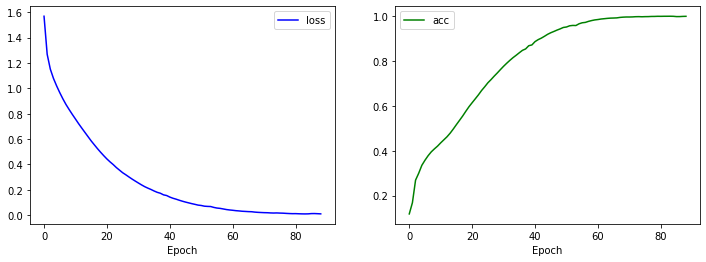

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['lm_acc'], 'g-', label='acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [ ]:
# 모델 생성
model = build_model(len(vocab), d_model, n_enc_seq, n_dec_seq)
# train weight로 초기화
model.load_weights(os.path.join(songys_dir, 'lstm_scale_dot.hdf5'))

In [ ]:
def do_chat(vocab, model, n_enc_seq, n_dec_seq, string):
    """
    seq2seq chat
    :param vocab: vocab
    :param model: model
    :param n_enc_seq: number of enc seqence
    :param n_dec_seq: number of dec seqence
    :param string: inpust string
    """
    # qeustion
    q = vocab.encode_as_pieces(string)
    q_id = [vocab.piece_to_id(p) for p in q][:n_enc_seq]
    q_id += [0] * (n_enc_seq - len(q_id))
    assert len(q_id) == n_enc_seq

    # answer
    a_id = [vocab.bos_id()]
    a_id += [0] * (n_dec_seq - len(a_id))
    assert len(a_id) == n_dec_seq

    # 처음부터 예측
    start_idx = 0

    for _ in range(start_idx, n_dec_seq - 1):
        outputs = model.predict((np.array([q_id]), np.array([a_id])))
        prob = outputs[0][start_idx]
        word_id = np.argmax(prob)
        if word_id == vocab.eos_id():
            break
        a_id[start_idx + 1] = int(word_id)
        start_idx += 1
    predict_id = a_id[1:start_idx + 1]
    predict_str = vocab.decode_ids(predict_id)
    return predict_str

In [ ]:
while True:
    string = input('질문 > ')
    string = string.strip()
    if len(string) == 0:
        break
    predict_str = do_chat(vocab, model, n_enc_seq, n_dec_seq, string)
    print(f'답변 > {predict_str}')

질문 > 안녕
답변 > 안녕하세요.
질문 > 반가워요
답변 > 저도 반가워요.
질문 > 밥 먹었니?
답변 > 맛있겠네요.
질문 > 너 이름이 뭐야?
답변 > 위로봇입니다.
질문 > 위로를 부탁해
답변 > 제가 위로해 드릴게요.
질문 > 고마워요
답변 > 감사합니다.
질문 > 안녕
답변 > 안녕하세요.
질문 > 잘가
답변 > 안녕.
질문 > 
